In [1]:
pip install geopandas rasterio scikit-learn matplotlib numpy pandas shapely

  Obtaining dependency information for rasterio from https://files.pythonhosted.org/packages/7e/1f/56462740694de764fde264051224fcbf800dad43cac92a66753153128866/rasterio-1.4.3-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for affine from https://files.pythonhosted.org/packages/0b/f7/85273299ab57117850cc0a936c64151171fac4da49bc6fba0dad984a7c5f/affine-2.4.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/25.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/25.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/25.5 MB 393.8 kB/s eta 0:01:05
   ---------------------------------------- 0.1/25.5 MB 901.1 kB/s eta 0:00:29
   ---------------------------------------- 0.2/25.5 MB 1.2 MB/s eta 0:00:22
   ---------------------------------------- 0.3/25.5 MB 1.3 MB/s eta 0:00:20
    --------------------------------------- 0.4/25.5 MB 1.3 MB/s eta 0:00:19
    --------------------------------------- 0.5/25.5 MB 1.5 MB/s

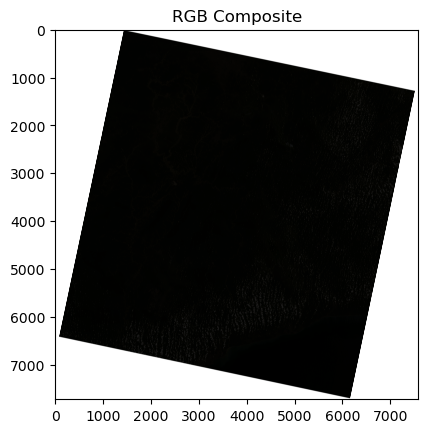

In [1]:
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

#Load satellite images (bands) 
bands = [r'C:/Users/FrancisAsanteNsiah/Desktop/STUFF\boj/My_Project/LCC-using-satellite-image-ML/satelliteImages/RT_LC09_L2SP_194056_20240417_20240418_02_T1_SR_B4.TIF',
         r'C:/Users/FrancisAsanteNsiah/Desktop/STUFF\boj/My_Project/LCC-using-satellite-image-ML/satelliteImages/RT_LC09_L2SP_194056_20240417_20240418_02_T1_SR_B3.TIF',
         r'C:/Users/FrancisAsanteNsiah/Desktop/STUFF\boj/My_Project/LCC-using-satellite-image-ML/satelliteImages/RT_LC09_L2SP_194056_20240417_20240418_02_T1_SR_B2.TIF'
        ]

images = [rasterio.open(band) for band in bands]



# Plot RGB composite
red = images[0].read(1)
green = images[1].read(1)
blue = images[2].read(1)

#Normalise the image
def normalize_band(band):
    return (band - band.min()) / (band.max() - band.min())

red = normalize_band(red)
green = normalize_band(green)
blue = normalize_band(blue)
rgb = np.dstack((red, green, blue))



# rgb = np.dstack((red, green, blue)) 
# rgb = np.clip(rgb, 0, 1)

plt.imshow(rgb)
plt.title("RGB Composite")
plt.show()

In [2]:
#load training data
# Load individual shapefiles and assign class labels
vegetation = gpd.read_file("C:/Users/FrancisAsanteNsiah/Desktop/STUFF/boj/My_Project/LCC-using-satellite-image-ML/trainingData/vegetation.shp")
vegetation['land_cover'] = 'vegetation'

waterbody = gpd.read_file("C:/Users/FrancisAsanteNsiah/Desktop/STUFF/boj/My_Project/LCC-using-satellite-image-ML/trainingData/waterbody.shp")
waterbody['land_cover'] = 'waterbody'

bareland = gpd.read_file("C:/Users/FrancisAsanteNsiah/Desktop/STUFF/boj/My_Project/LCC-using-satellite-image-ML/trainingData/bareland.shp")
bareland['land_cover'] = 'bareland'

In [3]:
import pandas as pd

#Combine into a single geodataframe
training_data = pd.concat([vegetation, waterbody, bareland], ignore_index=True)


In [4]:
#Save as a single shapefile
training_data.to_file("training_polygons.shp")

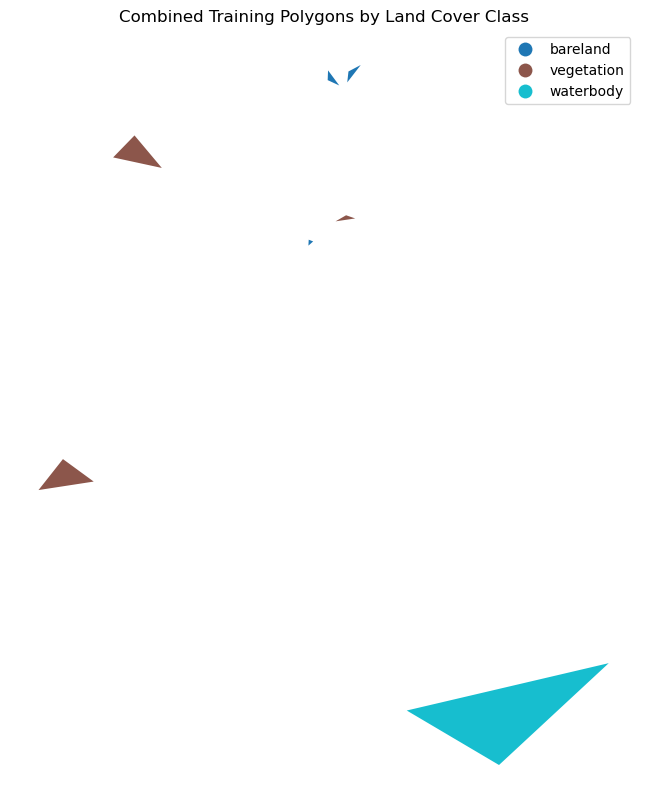

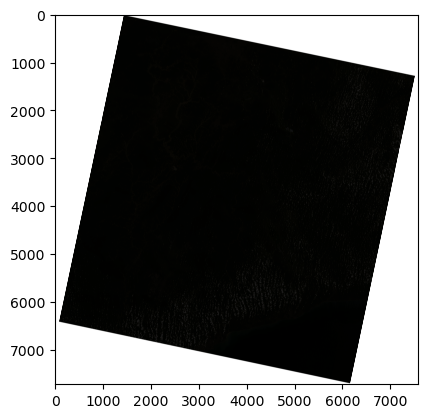

In [5]:
#Visualise trianing data
training_data.plot(column='land_cover', legend=True, figsize=(10, 10), cmap='tab10')
plt.title("Combined Training Polygons by Land Cover Class")
plt.axis('off')
plt.show()
plt.imshow(rgb)

In [6]:
#Check the CRS

with rasterio.open(r"C:/Users/FrancisAsanteNsiah/Desktop/STUFF\boj/My_Project/LCC-using-satellite-image-ML/satelliteImages/RT_LC09_L2SP_194056_20240417_20240418_02_T1_SR_B4.TIF") as src:
    raster_crs = src.crs
print("Raster CRS:", raster_crs)
print("")
print("Training data CRS:", training_data.crs)


Raster CRS: PROJCS["WGS 84 / UTM zone 30N",GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-3],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]

Training data CRS: EPSG:4326


In [7]:
#Reproject crs

training_data = gpd.read_file("training_polygons.shp")
#Reproject crs training data to match satellite 
training_data_prj = training_data.to_crs(images[0].crs)
print("Training data CRS:", training_data_prj.crs)

Training data CRS: PROJCS["WGS 84 / UTM zone 30N",GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-3],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


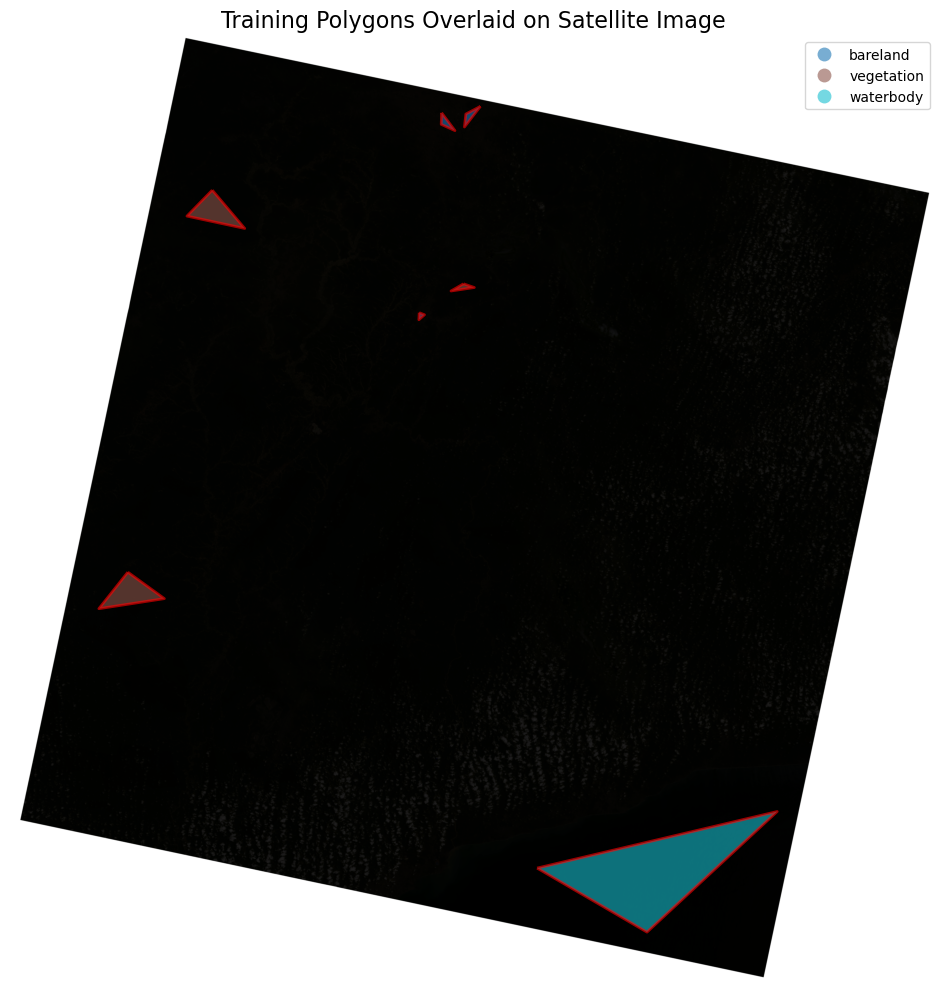

In [8]:
#Overlay training data on satellite image

image_bounds = src.bounds
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(rgb, extent=[image_bounds.left, image_bounds.right, image_bounds.bottom, image_bounds.top], origin='upper')

training_data_prj.plot(ax=ax,
                       column='land_cover',
                       cmap='tab10', 
                       alpha=0.6,   
                       edgecolor='red',
                       linewidth=2,  
                       legend=True)

plt.title("Training Polygons Overlaid on Satellite Image", fontsize=16) #
plt.axis("off") 
plt.tight_layout() 
plt.show()

In [9]:
import numpy as np
from rasterio.mask import mask

features = []
labels = []

for idx, row in training_data_prj.iterrows():
    geom = [row['geometry']]
    class_label = row['land_cover']
    
    band_values = []
    for image in images:
        out_image, _ = mask(image, geom, crop=True)
        band_values.append(out_image[0].flatten())
    
# Stack all bands and remove no-data values
    stacked = np.stack(band_values, axis=1)
    valid_mask = ~np.any(np.isnan(stacked), axis=1)
    stacked = stacked[valid_mask]
    
    features.extend(stacked.tolist())
    labels.extend([class_label] * stacked.shape[0])


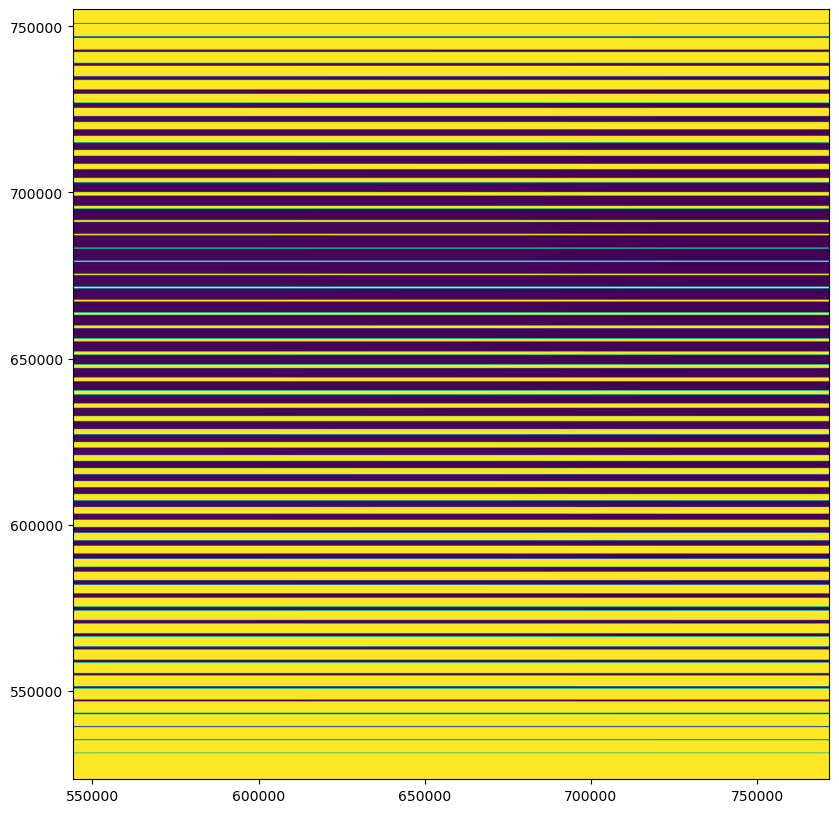

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(stacked,extent=[image_bounds.left, image_bounds.right, image_bounds.bottom, image_bounds.top], origin="upper")

In [15]:
#Build and train the ML model

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Convert to arrays
X = np.array(features)
y = np.array(labels)

# Encode string labels to numeric
le = LabelEncoder()
y_encoded = le.fit_transform(y)


# Split data
X_train, X_test, y_train, y_test = train_test_split(features, y_encoded, test_size=0.2, random_state=42)

# Train model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate model
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.97      0.29      0.45      8147
           1       1.00      0.42      0.59     64161
           2       0.90      1.00      0.95    388798

    accuracy                           0.91    461106
   macro avg       0.96      0.57      0.66    461106
weighted avg       0.92      0.91      0.89    461106

[[  2382     56   5709]
 [    68  26934  37159]
 [     0      2 388796]]


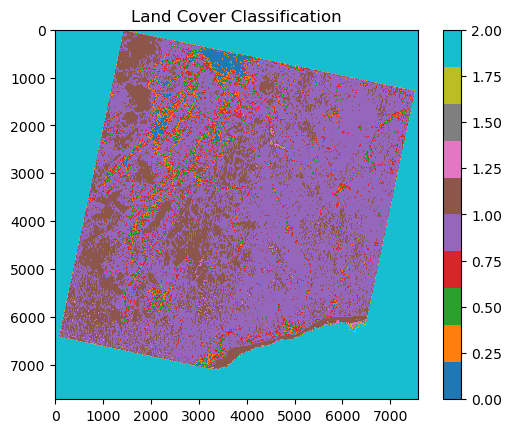

In [16]:
#Apply the model
# Read all bands as 2D arrays
band_arrays = [img.read(1).flatten() for img in images]
image_shape = images[0].read(1).shape
stacked_image = np.stack(band_arrays, axis=1)

# Predict classes
predicted_classes = clf.predict(stacked_image)

# Reshape to image dimensions
classified_image = predicted_classes.reshape(image_shape)

# Visualize
plt.imshow(classified_image, cmap='tab10')
plt.title("Land Cover Classification")
plt.colorbar()
plt.show()
